In [1]:
import os
import shutil

## Prepare Data

In [2]:
original_path = './COVID-19_Radiography_Dataset'
dirnames = []
for dirname in os.listdir(original_path):
    if os.path.isdir(os.path.join(original_path, dirname)):
        dirnames.append(dirname)
        
new_path = './COVID-19_Radiography_Dataset_prepared'
data_prc = 0.01 # percentage of images
split = {'train':0.7, 'val':0.2, 'test':0.1}

if os.path.exists(new_path):
    os.system("rm -rf "+ new_path)
os.makedirs(new_path)
for key, values in split.items():
    if split[key] > 0.0:
        os.makedirs(os.path.join(new_path, key))
        for dirname in dirnames:
            os.makedirs(os.path.join(new_path, key, dirname))
            

for dirname in os.listdir(original_path):
    if os.path.isdir(os.path.join(original_path, dirname)):
        img_names = [name for name in os.listdir(os.path.join(original_path, dirname))]
        for key in split.keys():
            for i in range(int(split[key] * data_prc * len(img_names))):
                shutil.copy(os.path.join(original_path, dirname, img_names[i]), 
                           os.path.join(new_path, key, dirname, img_names[i]))
                
train_dir = os.path.join(new_path, 'train')
val_dir = os.path.join(new_path, 'val')

ntrain = sum(len(files) for _, _, files in os.walk(train_dir))
nval = sum(len(files) for _, _, files in os.walk(val_dir))

print(ntrain, nval)

147 41


## ImageDataGenerator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import numpy as np
def preprocessing_fun(filename):
    #print(filename)
    #img = cv2.imread(filename)
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    image_sharp = cv2.filter2D(src=filename, ddepth=-1, kernel=kernel)
    return image_sharp

batch_size = 20
train_datagen = ImageDataGenerator(
    rescale=1./255,
#       rotation_range=10,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       shear_range=0.1,
#       zoom_range=0.1,
#       horizontal_flip=True,
#       fill_mode='nearest',
    preprocessing_function=preprocessing_fun,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size)


val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size)

Found 147 images belonging to 4 classes.
Found 41 images belonging to 4 classes.


## Train VGG16

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top = False,
                 input_shape = (150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=ntrain // batch_size,
      epochs=30,
      validation_data=val_generator,
      validation_steps=nval // batch_size)

2961 844


## Train Model

In [25]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(learning_rate=1e-4), 
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=ntrain // batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=nval // batch_size)

model.save('covid_noaug.h5')

/Volumes/MyFiles/Projects/COVID/covid/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
36/36 [==============================] - 12s 307ms/step - loss: 1.2009 - acc: 0.4729 - val_loss: 1.1406 - val_acc: 0.4700
Epoch 2/30
36/36 [==============================] - 11s 303ms/step - loss: 1.1310 - acc: 0.5174 - val_loss: 1.0725 - val_acc: 0.6100
Epoch 3/30
36/36 [==============================] - 11s 303ms/step - loss: 1.0463 - acc: 0.5814 - val_loss: 1.0017 - val_acc: 0.6150
Epoch 4/30
36/36 [==============================] - 11s 304ms/step - loss: 0.9746 - acc: 0.5911 - val_loss: 0.8782 - val_acc: 0.6300
Epoch 5/30
36/36 [==============================] - 11s 304ms/step - loss: 0.9032 - acc: 0.6120 - val_loss: 0.8112 - val_acc: 0.6450
Epoch 6/30
36/36 [==============================] - 11s 309ms/step - loss: 0.8491 - acc: 0.6592 - val_loss: 0.8172 - val_acc: 0.6650
Epoch 7/30
36/36 [==============================] - 11s 305ms/step - loss: 0.8253 - acc: 0.6551 - val_loss: 0.7863 - val_acc: 0.6600
Epoch 8/30
36/36 [==============================] - 11s 306ms/step - 

## Plot accuracy

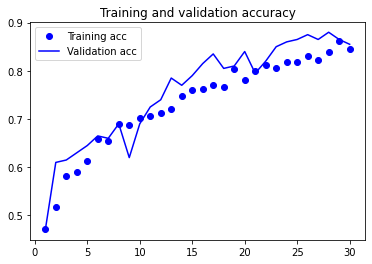

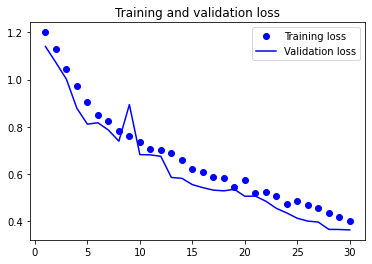

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Plot images from a generator

20


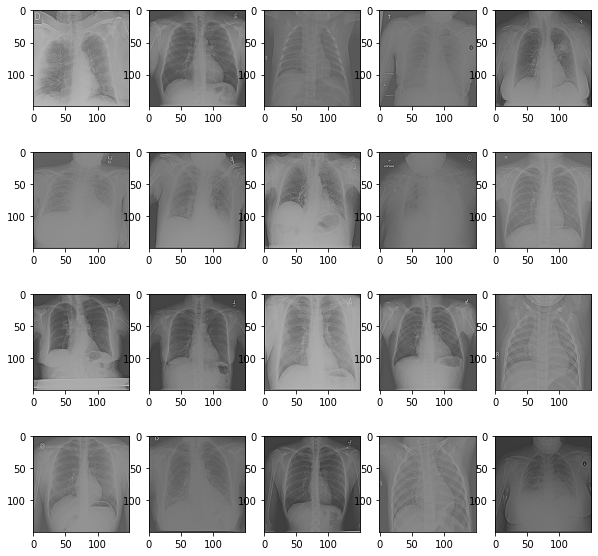

In [17]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for data_batch, labels_batch in train_generator:
    print(data_batch.shape[0])
    for i in range(1, data_batch.shape[0]+1):
        #plt.figure(i)
        plt.subplot(4,5,i)
        imgplot = plt.imshow(array_to_img(data_batch[i-1]))
#         if i % 4 == 0:
#             break
    break
plt.show()

## Visualizing intermediate activations

In [1]:
from tensorflow.keras.models import load_model

model = load_model('covid_noaug.h5');
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)     

2022-02-24 21:56:05.611902: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
lo = [layer.output for layer in model.layers[:8]]
lo

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_16')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d_16')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_17')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_17')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_18')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_18')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_19')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_19')>]

(1, 150, 150, 3)


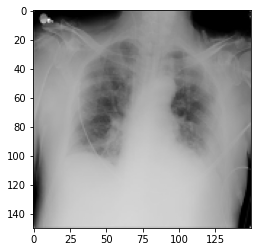

In [7]:
from tensorflow.keras.preprocessing import image 
import numpy as np
import os

new_path = './COVID-19_Radiography_Dataset_prepared'

img_path = os.path.join(new_path, 'test/COVID/COVID-1.png')

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /=255.
print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [8]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor) 

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


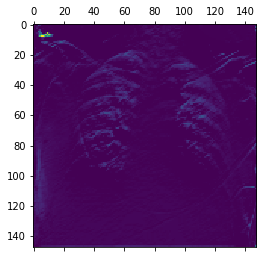

In [9]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

/Volumes/MyFiles/Projects/COVID/covid/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


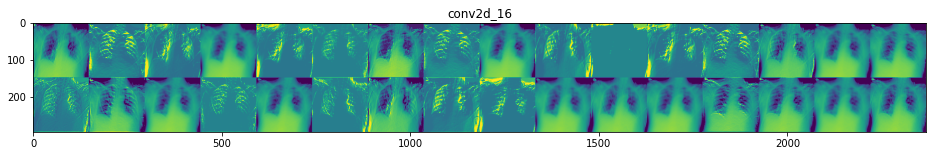

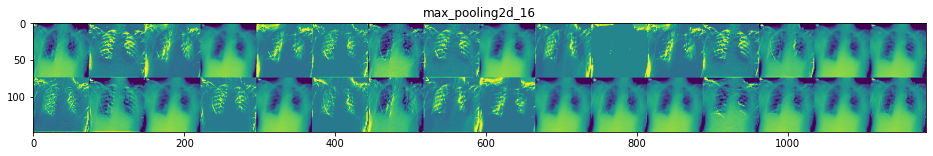

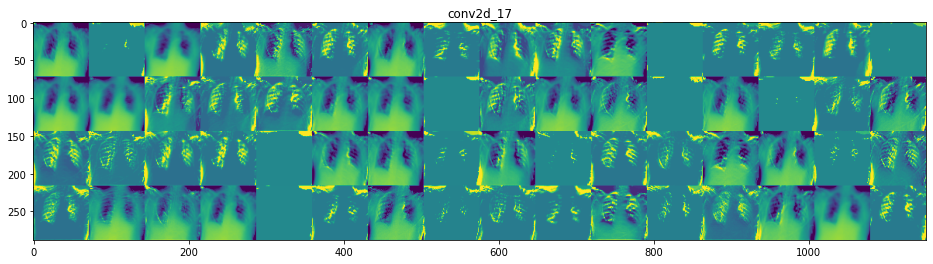

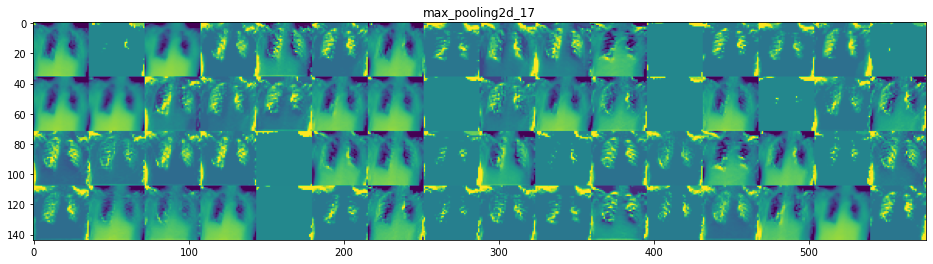

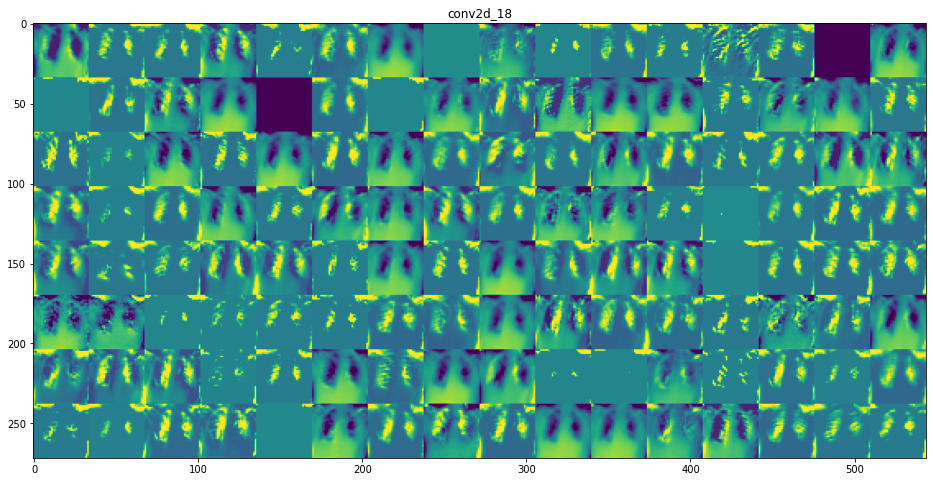

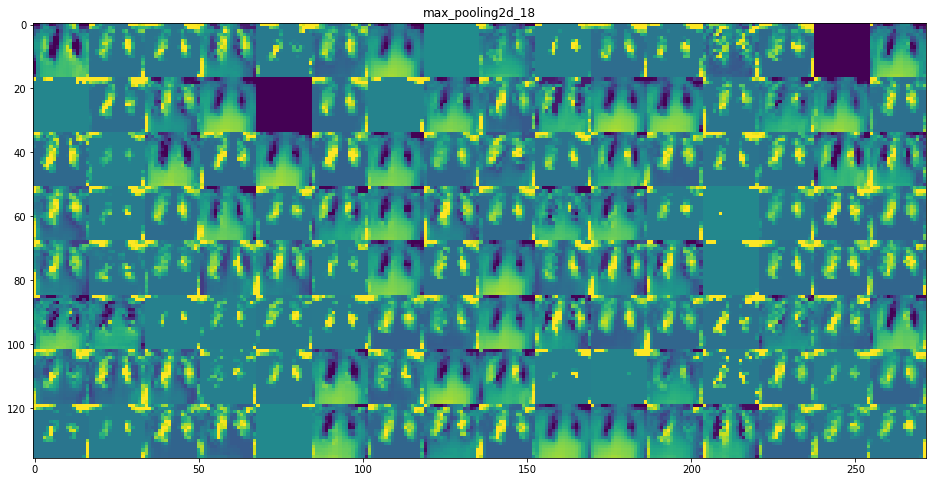

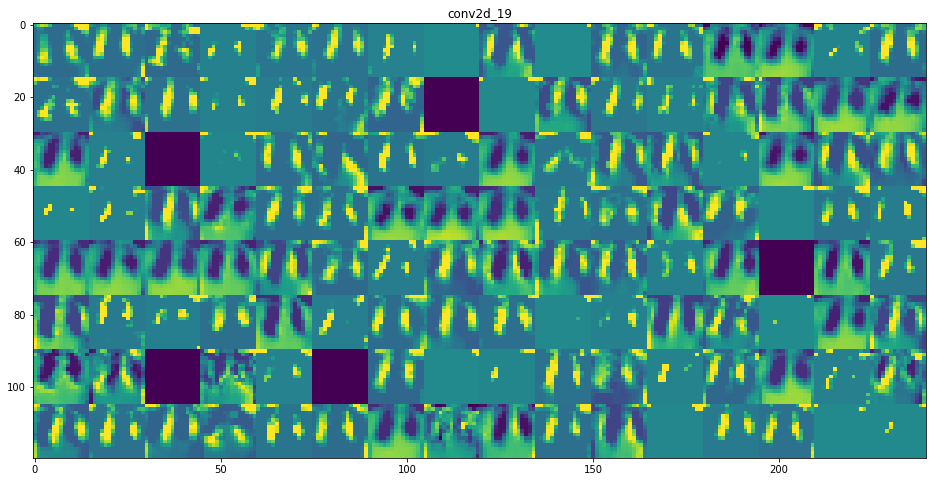

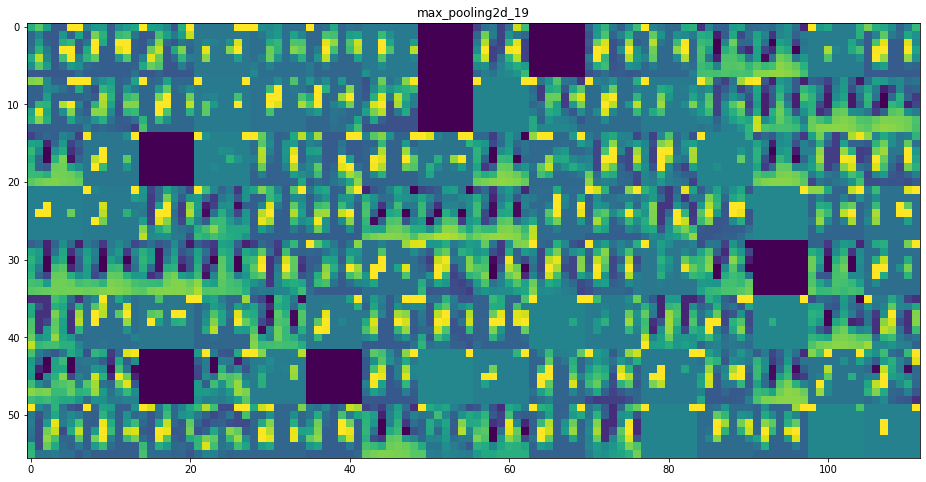

In [11]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## 5.4.2. Visualizing convnet filters

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

<tf.Tensor: shape=(1, 37, 37, 256), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 8.22960052e+01, ...,
          2.39053631e+00, 5.63412714e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 6.13385506e+01, ...,
          4.15069628e+00, 6.19014454e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 5.90235596e+01, ...,
          5.30565739e+00, 6.22093105e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 5.85142708e+01, ...,
          4.93673897e+00, 6.53364801e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 5.96797562e+01, ...,
          4.54225731e+00, 5.26381779e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 6.33355904e+01, ...,
          1.99998176e+00, 1.55919731e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.53726918e-01, 6.01403389e+01, ...,
          2.91106343e+00, 3.90180874e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.12606406e-01, ...,
         

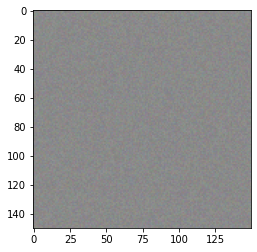

In [28]:
import numpy as np
import matplotlib.pyplot as plt

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
input_img_data /=255.
plt.imshow(input_img_data[0])

layer_output = model.get_layer(layer_name).output

feature_extractor = tf.keras.Model(inputs=model.input, outputs=layer_output)



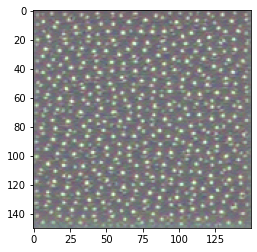

In [55]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        activation = feature_extractor(img)
        loss = tf.reduce_mean(activation[:, :, :, filter_index])

    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 40
    learning_rate = 10.
    img = np.random.random((1, 150, 150, 3))# * 20 + 128.
    #img /= 255.
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return img

plt.imshow(visualize_filter(0))

## 5.4.3. Visualizing heatmaps of class activation